In [1]:
#hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

# Training a Digit Classifier

We'll explore the steps involved in building a simple digit classifier. We will:
- Discuss the role of arrays and tensors, and introduce broadcasting, a powerful technique that makes operations on these data structures more expressive.
- Define a suitable loss function for this classification task, and introduce the concept of mini-batches to optimize the training process.
- Explain the mathematical operations performed by a basic neural network.

By the end, we’ll combine all these pieces to create a model capable of classifying images of digits.

## Image Classification

We will build an image classifier to explore the key steps and techniques in the deep learning pipeline.

In image classification, our goal is to assign a label $ y $ to each image $ X $ from a set of possible classes $ C $, where $ C $ could be categories like pet breeds, disease states, or cell types. Mathematically, we can represent this as a function $ f: X \rightarrow y $, which maps each image to a class label. This is achieved by training a model to minimize a loss function that quantifies the difference between predicted and true labels.

For binary classification (e.g., identifying the presence or absence of a disease), the output is a single probability score $ p $, with $ y = 1 $ if $ p \geq 0.5 $ and $ y = 0 $ otherwise. For multi-class classification (e.g., identifying different types of tumors), the model outputs a vector of probabilities $ \mathbf{p} = [p_1, p_2, \dots, p_k] $ for each class $ k $, where $ \sum_{i=1}^k p_i = 1 $.



## Pixels: The Foundations of Computer Vision

Our goal is to build a model that can classify an image as either a "3" or a "7." To start, let's download a sample of the MNIST dataset that includes images of just these digits:

In [2]:
# Load the MNIST sample dataset
path = untar_data(URLs.MNIST_SAMPLE)

# Check the directory contents
path.ls()

(#3) [Path('C:/Users/biagi/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/biagi/.fastai/data/mnist_sample/train'),Path('C:/Users/biagi/.fastai/data/mnist_sample/valid')]

The MNIST dataset follows a common layout for machine learning datasets, with separate folders for the training and validation sets. Inside the training set, there are folders named for each label (3 and 7), which contain the images for each respective digit.


In [3]:
(path/'train').ls()

(#2) [Path('C:/Users/biagi/.fastai/data/mnist_sample/train/3'),Path('C:/Users/biagi/.fastai/data/mnist_sample/train/7')]

In this dataset, "3" and "7" are the *labels* or *targets*. Let’s take a look at a sample image of a handwritten "3":

In [4]:
# Get the path for the images of "3"
threes = (path/'train'/'3').ls().sorted()

# Open and display an example image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3.show()

Images in Python are often represented by the `Image` class from the *Python Imaging Library* (PIL). Converting an image to a numerical format, like a NumPy array or PyTorch tensor, allows us to perform mathematical operations directly on the image data.

In [5]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Each pixel in the image has a value between 0 and 255, where 0 represents black and 255 represents white, with shades of gray in between. Converting the image to a PyTorch tensor allows us to manipulate and process it further:

In [6]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

## Pixel Similarity

As a simple baseline model, let's calculate the average pixel values for all images of "3" and "7" separately. This will give us an "ideal" version of each digit, which we can use for comparison. To classify an image, we’ll check which of these ideal representations the image most closely resembles.

<Axes: >

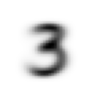

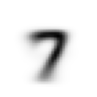

In [7]:
# Load images of 3s and 7s as tensors
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in (path/'train'/'7').ls().sorted()]

# Stack tensors and normalize
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

# Calculate the average image (mean) for each digit
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

# Display the "ideal" 3 and 7
show_image(mean3)
show_image(mean7)

This approach provides a very basic model: for any new image, we calculate its "distance" from the average 3 and average 7, then classify it as the closest match. Distance can be calculated using either:
- **Mean Absolute Difference** (L1 norm)
- **Root Mean Squared Error** (L2 norm)

If the distance to the ideal 3 is smaller, we classify the image as a 3, otherwise as a 7.

Let's try both of these now:

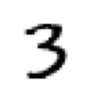

In [9]:
a_3 = stacked_threes[1]
show_image(a_3);

In [10]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [11]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

>  Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

## Computing Metrics

To evaluate the performance of our model, we need a way to measure how well it’s doing. This measurement is called a **metric**. Metrics are calculated based on the model’s predictions compared to the actual labels in the dataset. For classification tasks like this, a common metric is **accuracy**.

In our case, we want to determine if each image is classified correctly as either a "3" or a "7." Accuracy for this task can be computed by:
1. Calculating the model’s prediction for each image.
2. Checking if the prediction matches the actual label.
3. Averaging these correct/incorrect results across the entire dataset.

We have two sets of validation images: one for 3s and one for 7s. Let’s load and prepare these validation sets as tensors:

In [12]:
# Load and normalize validation sets
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

# Check shapes of validation tensors
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Each tensor has the shape `[number_of_images, height, width]`, where:
- `valid_3_tens` has 1,010 images of 3s.
- `valid_7_tens` has 1,028 images of 7s.
  
This setup allows us to test our function across both categories and compute accuracy based on all validation images.

### PyTorch Tensors and Broadcasting

Tensors are multidimensional arrays that enable fast computation in PyTorch. Unlike Python lists, which are slow, tensors allow us to perform large-scale mathematical operations quickly.

For instance, let's add 1 to each element in a tensor and multiply it by another tensor, without any Python loops:

```python
tns = tensor([[1,2,3],[4,5,6]])
tns + 1
tns * 1.5
```

Broadcasting is a powerful technique that allows us to perform operations between tensors of different shapes. For example, subtracting an "ideal" digit from each image in a batch is possible because PyTorch will "broadcast" the ideal digit to match the batch size.

### Defining a Distance Function with Broadcasting

To classify an image, we need to calculate its "distance" from the "ideal" 3 and 7 (the averages we calculated earlier). A useful function for calculating this distance is **mean absolute error** (MAE).

With broadcasting, we can apply the same distance calculation to an entire set of images without writing loops. Here’s our distance function:


In [13]:
# Define distance function using broadcasting
def mnist_distance(a, b): 
    return (a - b).abs().mean((-1, -2))

# Calculate distance from an example image to the ideal 3
a_3 = valid_3_tens[0]
mnist_distance(a_3, mean3)

tensor(0.1280)

When we pass `valid_3_tens` (all 3s in the validation set) and `mean3` (the ideal 3) to this function, broadcasting automatically expands `mean3` to match the shape of `valid_3_tens`, calculating the distance for each image in the set:

In [14]:
# Calculate distance for all 3s in the validation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist.shape  # Output should be a vector of distances

torch.Size([1010])

Broadcasting makes this possible by "stretching" `mean3` to align with each image in `valid_3_tens`, allowing the distance function to operate on all images simultaneously. This avoids the need for loops and makes the computation faster and more efficient.

### Classifying an Image with Distance

To classify a new image, we compare its distance to `mean3` and `mean7`. If it’s closer to `mean3`, we classify it as a 3; if it’s closer to `mean7`, we classify it as a 7:

In [15]:
# Define classification function
def is_3(x): 
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

# Test classification on a sample 3
is_3(a_3)

tensor(True)

For the validation set, we can use broadcasting to classify every image at once:

In [16]:
# Classify all 3s in the validation set
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

### Calculating Accuracy

To compute accuracy, we calculate the proportion of correct predictions:
- For images of 3s, we check if the model predicted 3 (output is `True`).
- For images of 7s, we check if the model predicted 7 (output is `False`).

Here’s how to calculate accuracy for each set and the overall accuracy:

In [17]:
# Calculate accuracy for each digit
accuracy_3s = is_3(valid_3_tens).float().mean()  # Accuracy on 3s
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()  # Accuracy on 7s

# Calculate overall accuracy
overall_accuracy = (accuracy_3s + accuracy_7s) / 2
accuracy_3s, accuracy_7s, overall_accuracy

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In this example, `accuracy_3s` and `accuracy_7s` represent the accuracy for classifying 3s and 7s, respectively. By averaging these, we get an overall measure of the model's performance.


## Defining a Loss Function

In deep learning, the loss function is a critical component used to guide the training process. It quantifies how well our model’s predictions match the target values (labels), allowing us to improve the model by minimizing this loss over successive iterations.

Our goal here is to create a loss function that:
1. Produces a value reflecting how far the model's predictions are from the true labels.
2. Has a gradient that can guide the optimization process, making it possible to update the model's parameters effectively.

### Why Not Use Accuracy as a Loss Function?

A straightforward choice for measuring model performance is **accuracy**, which calculates the proportion of correct predictions. However, accuracy is unsuitable as a loss function for two reasons:
1. **Flat gradients**: Small changes in weights often do not affect accuracy, because the predictions remain classified the same way (correct or incorrect). This causes "flat" gradients, making it difficult to improve the model.
2. **Discrete metric**: Accuracy is a discrete measure that doesn’t capture "how wrong" a prediction is. For instance, if the model is very close to the correct answer, accuracy won’t reflect this, but a good loss function should.

For these reasons, accuracy is often used as a **metric** (to evaluate the model’s performance), while the **loss function** drives the learning process.

### Defining a Loss Function for Binary Classification

In our MNIST task, we are trying to classify images as either a "3" or a "7." We can treat this as a binary classification problem:
- **1** for images of "3".
- **0** for images of "7".

Our goal is to ensure that the model outputs values close to 1 for images of "3" and values close to 0 for images of "7." A common approach in binary classification is to use the **mean absolute error** or **cross-entropy loss**.

In this example, we'll use a custom function that measures the distance between the model's predictions and the true labels, ensuring that:
- For images of "3" (target 1), the prediction is close to 1.
- For images of "7" (target 0), the prediction is close to 0.


### Implementing a Simple Loss Function

Suppose we have three images with labels `[1, 0, 1]` (representing "3," "7," and "3"). Let's say our model’s predictions are `[0.9, 0.4, 0.2]`. These predictions mean:
- The model is confident the first image is a 3.
- The model is slightly confident that the second image is a 7.
- The model incorrectly predicts the third image as a 7.

Here’s a simple loss function to measure how far the predictions are from the target labels:

In [18]:
# Define sample targets and predictions
targets = tensor([1, 0, 1])
predictions = tensor([0.9, 0.4, 0.2])

# Define the MNIST loss function
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

In this function:
- `torch.where(targets == 1, 1 - predictions, predictions)` calculates the distance between each prediction and the target (1 or 0).
- If `targets == 1` (for a 3), we calculate `1 - prediction` to measure how close the prediction is to 1.
- If `targets == 0` (for a 7), we simply use `prediction` to measure how close it is to 0.
- We then take the mean of all these distances to get the overall loss.

Let’s test it with our example values:

In [19]:
# Calculate loss
mnist_loss(predictions, targets)

tensor(0.4333)

A lower loss indicates that the predictions are closer to the targets. For instance, if we change the prediction for the third image from `0.2` to `0.8`, which is closer to the target of 1, the loss decreases:

In [20]:
mnist_loss(tensor([0.9, 0.4, 0.8]), targets)

tensor(0.2333)

### Ensuring Predictions are Between 0 and 1 with the Sigmoid Function

To use the loss function effectively, we need to ensure that predictions fall between 0 and 1. This can be done using the **sigmoid function**, defined as:

$$ \text{sigmoid}(x) = \frac{1}{1 + e^{-x}} $$

The sigmoid function squashes any input to a range between 0 and 1, making it perfect for binary classification tasks. In PyTorch, we can use `torch.sigmoid` for this purpose.

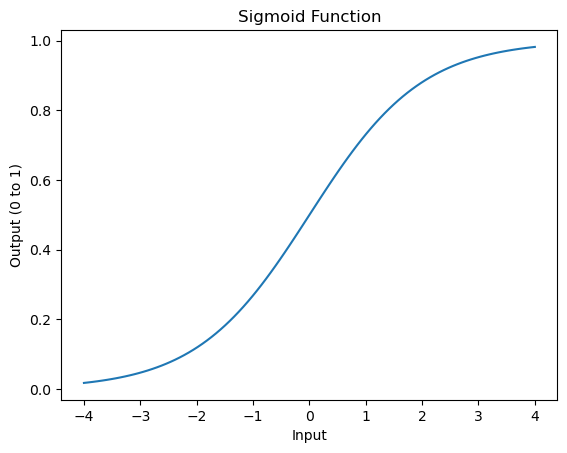

In [21]:
# Define the sigmoid function (PyTorch version)
def sigmoid(x): return 1 / (1 + torch.exp(-x))

# Plot the sigmoid function
import matplotlib.pyplot as plt
x = torch.linspace(-4, 4, 100)
plt.plot(x, sigmoid(x))
plt.title("Sigmoid Function")
plt.xlabel("Input")
plt.ylabel("Output (0 to 1)")
plt.show()

The sigmoid function maps any real-valued input to a value between 0 and 1, which means that predictions can now represent probabilities. 

### Updating the Loss Function with Sigmoid

We can update our `mnist_loss` function to first apply the sigmoid to the predictions. This ensures that the loss function works even if the model outputs are not constrained between 0 and 1:

In [22]:
# Updated MNIST loss function with sigmoid
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

### Why Do We Need a Separate Loss Function?

The key difference between **metrics** (like accuracy) and **loss functions** is their purpose:
- **Metrics**: Used to evaluate model performance, providing a number that indicates how well the model performs on a specific task. Metrics don’t need to be differentiable, as they’re not used in the optimization process.
- **Loss Functions**: Guide the learning process by calculating gradients, which indicate how to adjust model parameters to improve performance. Loss functions must be smooth and differentiable, as their derivatives are used in optimization.

By using this custom loss function, we provide a signal that tells the model to get closer to correct answers, even when predictions are slightly off.

## Optimization with Stochastic Gradient Descent (SGD) and Mini-Batches

In machine learning, **Stochastic Gradient Descent (SGD)** is an optimization technique used to minimize the loss function, which guides the learning process of a model. Unlike regular **Gradient Descent**, which computes the gradient of the loss with respect to each parameter over the entire dataset, SGD approximates this by computing gradients over small, random subsets of the data called **mini-batches**.

SGD allows for faster training and can lead to better generalization due to the randomness in mini-batch sampling, which helps the model avoid getting stuck in certain local minima.



### Why Use Mini-Batches? 

Using mini-batches instead of the whole dataset or a single data item for each gradient update has several advantages:

1. **Faster Computation**: Calculating gradients over the entire dataset can be slow, especially for large datasets. Mini-batches allow us to update model parameters more frequently without waiting to process the whole dataset.
   
2. **Stable Gradient Estimates**: A single data item may produce a noisy and unstable gradient estimate, while the entire dataset provides a more accurate but computationally expensive estimate. Mini-batches provide a balance between these two, resulting in more stable gradient updates.

3. **Optimized GPU Utilization**: When using hardware accelerators like GPUs, mini-batches allow for parallel computations, maximizing the utilization of these resources.

4. **Improved Generalization**: The random sampling of mini-batches introduces stochasticity (randomness) in parameter updates, helping the model avoid overfitting and improve generalization.


### Choosing a Batch Size

At the heart of the decision to use minibatches is computational efficiency.
Processing single observations requires us to perform many single matrix-vector (or even vector-vector)
multiplications, which is quite expensive and which incurs a significant
overhead on behalf of the underlying deep learning framework. This
applies both to evaluating a network when applied to data (often
referred to as inference) and when computing gradients to update
parameters. That is, this applies whenever we perform
$\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ where

$$ \mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w}) $$

We can increase the *computational* efficiency of this operation by
applying it to a minibatch of observations at a time. That is, we
replace the gradient $\mathbf{g}_t$ over a single observation by
one over a small batch

$$ \mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}) $$

Let's see what this does to the statistical properties of
$\mathbf{g}_t$: since both $\mathbf{x}_t$ and also all
elements of the minibatch $\mathcal{B}_t$ are drawn uniformly at
random from the training set, the expectation of the gradient remains
unchanged. The variance, on the other hand, is reduced significantly.
Since the minibatch gradient is composed of
$b \stackrel{\textrm{def}}{=} |\mathcal{B}_t|$ independent
gradients which are being averaged, its standard deviation is reduced by
a factor of $b^{-\frac{1}{2}}$. This, by itself, is a good thing,
since it means that the updates are more reliably aligned with the full
gradient.

Naively this would indicate that choosing a large minibatch
$\mathcal{B}_t$ would be universally desirable. Alas, after some
point, the additional reduction in standard deviation is minimal when
compared to the linear increase in computational cost. So, we may say that:
- **Larger batch sizes** produce more stable gradient estimates, but training may be slower per update step.
- **Smaller batch sizes** allow for faster updates but may produce noisy gradients, which can make training less stable.

Then, in practice we pick a minibatch that is large enough to offer good computational
efficiency while still fitting into the memory of a GPU.



### Shuffling the Data

To prevent the model from seeing data in a fixed order, which could introduce unwanted patterns in updates, it’s standard practice to shuffle the dataset before dividing it into mini-batches. Shuffling the data in each epoch ensures that the model doesn’t rely on any specific order in the data.

PyTorch provides the `DataLoader` class, which automatically handles shuffling and mini-batch creation. Here’s a simple example of using `DataLoader` to create mini-batches from a dataset:



In [23]:
from torch.utils.data import DataLoader

# Sample data for demonstration
data = range(20)

# Create a DataLoader with batch size 5 and shuffling enabled
dl = DataLoader(data, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3,  7,  0,  8, 10]),
 tensor([ 4, 17,  1, 16, 12]),
 tensor([ 5, 15, 13, 11, 19]),
 tensor([14,  6,  9,  2, 18])]

In this example, `dl` creates batches of size 5, and the `shuffle=True` argument ensures that the data order is randomized with each epoch.



### Applying Mini-Batches to Images and Labels

For our MNIST classification task, we need to process both the images (features) and the labels (targets). Here’s how we can create a `DataLoader` for the MNIST dataset:

1. **Combine images and labels** into a PyTorch Dataset.
2. **Use a DataLoader** to create mini-batches of this dataset.



In [28]:
# Create the dataset for training
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
train_y = tensor([1] * len(stacked_threes) + [0] * len(stacked_sevens)).unsqueeze(1)
train_dataset = list(zip(train_x, train_y))
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

# Create the DataLoader for mini-batch processing
batch_size = 256
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256)


The `DataLoader` here will yield mini-batches of 256 images and their corresponding labels, shuffling the dataset in each epoch.



### Implementing an SGD Step with Mini-Batches

For each mini-batch, we need to:
1. **Calculate predictions** based on the current model parameters.
2. **Compute the loss** to see how far these predictions are from the true labels.
3. **Calculate gradients** with respect to each parameter.
4. **Update parameters** by subtracting a small proportion (learning rate) of the gradient from each parameter.

Here’s an implementation of one epoch of SGD with mini-batches:


In [29]:
# Define the learning rate
learning_rate = 0.1

# Training loop for one epoch
def train_epoch(model, train_dl, optimizer):
    for xb, yb in train_dl:
        # Forward pass: calculate predictions
        preds = model(xb)
        
        # Calculate loss
        loss = mnist_loss(preds, yb)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()


### Updating Parameters with `optimizer.step()`

The line `optimizer.step()` updates the parameters using the computed gradients. We then use `optimizer.zero_grad()` to reset gradients before the next mini-batch; otherwise, PyTorch accumulates gradients, which would lead to incorrect updates.



### Mini-Batch Accuracy Calculation

To evaluate the model’s performance, we can compute the accuracy on the validation set. For each mini-batch, we check if each prediction matches the true label and average these correct predictions.

In [30]:
# Define accuracy calculation function
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

# Validation accuracy calculation
def validate_epoch(model, valid_dl):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)


### Putting It All Together

We can now use these functions to train our model over several epochs, updating the parameters based on each mini-batch and calculating the accuracy on the validation set at the end of each epoch.


In [31]:
# Define the number of epochs
epochs = 5

# Initialize model and optimizer
model = nn.Linear(28*28, 1)  # Simple linear model for demonstration
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    train_epoch(model, train_dl, optimizer)
    print(f"Epoch {epoch+1} accuracy:", validate_epoch(model, valid_dl))

Epoch 1 accuracy: 0.9657
Epoch 2 accuracy: 0.9687
Epoch 3 accuracy: 0.9691
Epoch 4 accuracy: 0.9691
Epoch 5 accuracy: 0.9701


## Creating an Optimizer

An **optimizer** is an essential component in training a neural network, responsible for updating the model's parameters (weights and biases) based on the computed gradients. This process is typically done after each mini-batch, where the optimizer adjusts the parameters in the direction that minimizes the loss function.

### Why Do We Need an Optimizer?

In our previous section, we implemented Stochastic Gradient Descent (SGD) manually by:
1. Calculating gradients for each parameter using backpropagation.
2. Subtracting a fraction of the gradient (scaled by the learning rate) from each parameter.

While this process works, it can be simplified and optimized further using dedicated optimizers. PyTorch provides several built-in optimizers, each with different strategies for updating parameters. Using these optimizers streamlines the code and allows us to experiment with different optimization techniques easily.

### Common Optimizers in Deep Learning

1. **SGD (Stochastic Gradient Descent)**: Updates parameters by subtracting a fraction of the gradient. This method is simple but can be slow and may oscillate around local minima.
  
2. **Momentum-based SGD**: Builds on SGD by accumulating gradients in the direction of steepest descent, which helps accelerate convergence. 

3. **Adam (Adaptive Moment Estimation)**: Uses adaptive learning rates for each parameter, combining the ideas of momentum and adaptive learning rates, making it popular for many deep learning applications.

For this section, we'll start by creating a basic custom optimizer similar to SGD, then show how to use PyTorch’s built-in optimizers.

### Custom Basic Optimizer

Let’s define a simple optimizer called `BasicOptim` that implements standard SGD. This optimizer will:
1. Store the parameters to be updated.
2. Take a step size (learning rate) to scale the updates.
3. Include a `step` method to update each parameter by subtracting the product of the gradient and learning rate.
4. Reset gradients after each update to avoid accumulating them.

Here’s an implementation of a basic optimizer:

In [32]:
# Define a custom basic optimizer
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)  # Parameters to optimize
        self.lr = lr                # Learning rate
    
    def step(self):
        # Update each parameter by its gradient
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self):
        # Set gradients to None for each parameter
        for p in self.params:
            p.grad = None


### Using `BasicOptim` with a Model

To use this optimizer, we pass the model’s parameters to `BasicOptim` and specify a learning rate. Here’s a simple training loop that demonstrates how to use this custom optimizer:


In [33]:
# Initialize model and optimizer
model = nn.Linear(28*28, 1)  # Simple linear model for demonstration
opt = BasicOptim(model.parameters(), lr=0.1)

# Training loop for one epoch
for xb, yb in train_dl:
    # Forward pass: calculate predictions
    preds = model(xb)
    
    # Calculate loss
    loss = mnist_loss(preds, yb)
    
    # Backward pass: compute gradients
    loss.backward()
    
    # Update parameters and zero gradients
    opt.step()
    opt.zero_grad()


In this example:
- `opt.step()` updates each parameter by subtracting the scaled gradient.
- `opt.zero_grad()` resets gradients for each parameter, ensuring that gradients from one mini-batch don’t interfere with the next.


### Using PyTorch’s Built-in Optimizers

While `BasicOptim` demonstrates the core concept of SGD, PyTorch provides a built-in `SGD` optimizer, which includes additional features like momentum. Using PyTorch’s `torch.optim` library simplifies optimization and provides more options.

Here’s an example of using PyTorch’s built-in `SGD` optimizer with momentum:


In [34]:
from torch.optim import SGD

# Initialize model and optimizer
model = nn.Linear(28*28, 1)
opt = SGD(model.parameters(), lr=0.1, momentum=0.9)

# Training loop
for xb, yb in train_dl:
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

With PyTorch’s `SGD` optimizer, we only need to specify the learning rate and optionally, a momentum factor. The optimizer handles both the parameter updates and gradient reset internally.

### Switching to the Adam Optimizer

Adam (Adaptive Moment Estimation) is another popular optimizer that automatically adjusts learning rates for each parameter based on historical gradients and updates. This approach often improves convergence, especially in deep networks.

Switching to Adam requires only a change in the optimizer initialization, while the training loop remains the same:


In [35]:
from torch.optim import Adam

# Initialize model and optimizer
model = nn.Linear(28*28, 1)
opt = Adam(model.parameters(), lr=0.001)  # Lower learning rate for Adam

# Training loop
for xb, yb in train_dl:
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()


With Adam, you typically use a lower learning rate (e.g., `0.001`) than with SGD, as Adam adapts the learning rate dynamically during training.


The fastai library simplifies training by integrating the optimizer, loss function, and metrics within a single class, the `Learner`. To use `Learner`, we need to:
1. Create a `DataLoaders` object from our training and validation data.
2. Pass the model, optimizer, loss function, and metrics to `Learner`.

In [37]:
from fastai.vision.all import Learner, DataLoaders, Adam 

# Create DataLoaders
dls = DataLoaders(train_dl, valid_dl)

# Initialize Learner with model, optimizer, and metrics
learn = Learner(dls, model, opt_func=Adam, loss_func=mnist_loss, metrics=batch_accuracy)

# Train model using fit
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.112948,0.086621,0.967615,00:00
1,0.080888,0.063943,0.970069,00:00
2,0.062337,0.053072,0.970069,00:00
3,0.051248,0.046404,0.972522,00:00
4,0.043826,0.041867,0.973994,00:00
5,0.038403,0.038589,0.973994,00:00
6,0.034838,0.035652,0.975957,00:00
7,0.031702,0.033551,0.977920,00:00
8,0.029177,0.031640,0.978410,00:00
9,0.027235,0.030236,0.978410,00:00


With `Learner`, we can use the `fit` method to train our model over multiple epochs, making it easier to manage training while automatically handling optimizations.

## Adding a Nonlinearity

So far, we have only used linear transformations, which are limited in their capacity to capture complex patterns. Adding a **nonlinear activation function** like the *ReLU* (Rectified Linear Unit) between layers gives our model the ability to approximate more complex functions.

In [64]:
import torch.nn.functional as F

# Define a simple neural network
simple_net = nn.Sequential(nn.Linear(28*28, 1), nn.ReLU())

In [65]:
learn = Learner(dls, simple_net, opt_func=Adam,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [66]:
#hide_output
learn.fit(40, 0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.350354,0.307095,0.866536,00:00
1,0.309842,0.287336,0.912659,00:00
2,0.292670,0.279801,0.929343,00:00
3,0.282408,0.275418,0.937193,00:00
4,0.276669,0.272627,0.940628,00:00
5,0.272500,0.270300,0.952895,00:00
6,0.270921,0.268845,0.952404,00:00
7,0.268304,0.267622,0.957311,00:00
8,0.266692,0.266830,0.955839,00:00
9,0.265534,0.265906,0.963199,00:00


The training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

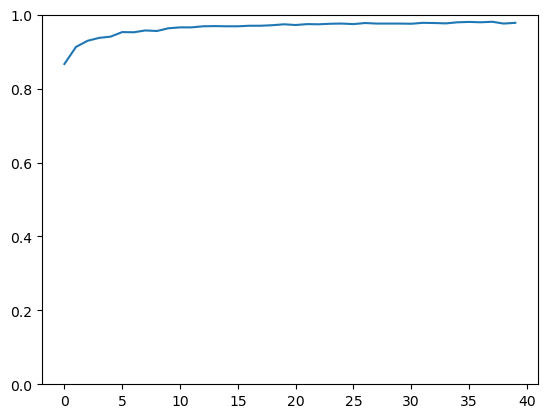

In [69]:
plt.plot(L(learn.recorder.values).itemgot(2), scaley=False);

And we can view the final accuracy:

In [68]:
learn.recorder.values[-1][2]

0.9779195189476013